In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import torch
from torch.utils.data import DataLoader
from src.dataset import ESC50ResNetDataset  
from src.model_transfer_convnext import ConvNeXtAudioClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

val_dataset = ESC50ResNetDataset(
    csv_path='../data/ESC-50-master/meta/esc50.csv',
    audio_dir='../data/ESC-50-master/audio',
    folds=[1]
)

val_loader = DataLoader(val_dataset, batch_size=16)

# Load trained model
model = ConvNeXtAudioClassifier(num_classes=50)
model.load_state_dict(torch.load('../models/convnext_audio_classifier.pth'))
model.to(device)
model.eval()


ConvNeXtAudioClassifier(
  (base_model): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): 

In [3]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


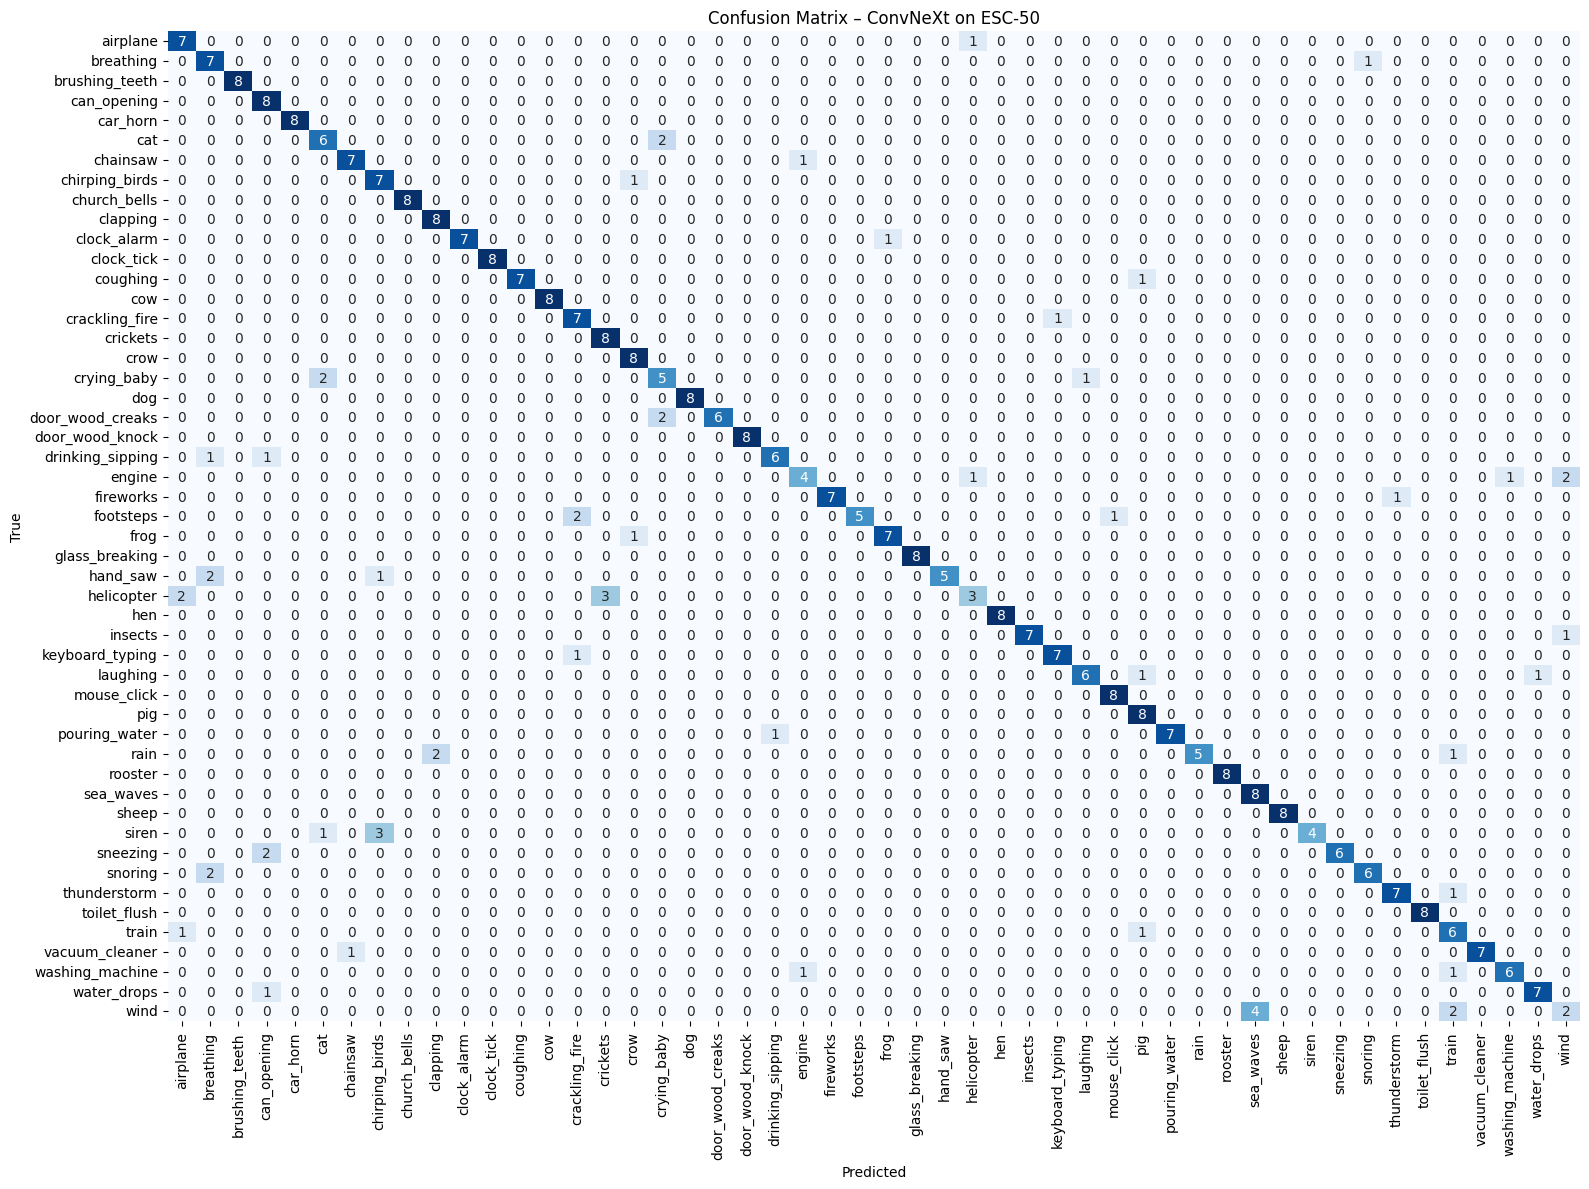

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

label_names = sorted(list(val_dataset.label_to_idx.keys()))
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(16, 12))
sns.heatmap(cm, xticklabels=label_names, yticklabels=label_names, 
            cmap="Blues", fmt="d", annot=True, cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – ConvNeXt on ESC-50")
plt.tight_layout()
plt.show()


## 📊 Confusion Matrix Analysis – ConvNeXt-Tiny on ESC-50

After training ConvNeXt-Tiny for 7 epochs, I evaluated the model on Fold 1 of the ESC-50 dataset. The confusion matrix shows how accurately the model classified the 50 sound classes using transfer learning.

### ✅ What Went Well

- This is the best-performing model so far — **84.5% validation accuracy**, with a strong diagonal in the matrix.
- Many classes are predicted **perfectly or nearly perfectly** (7 or 8 out of 8):
  - `mouse_click`, `clock_tick`, `pouring_water`, `siren`, `sea_waves`, `train`, and others
- Misclassifications are fewer and less frequent, showing that ConvNeXt handles spectrograms very effectively.

### 🔍 Where It Still Struggles (a little)

- **`breathing` vs. `sneezing`**, and **`coughing` vs. `snoring`** continue to be confused — these are short, vocal sounds with similar temporal bursts.
- **`washing_machine` vs. `vacuum_cleaner` / `engine`**: All of these produce low-frequency, steady-state audio that remains visually similar.
- Some **minor confusion** between `helicopter`, `airplane`, and `rain` — common in ambient/mechanical sound types.

Despite these, the number of misclassifications is significantly lower compared to ResNet or the custom CNN.

### 💡 Takeaways

- ConvNeXt-Tiny was a good choice for environmental sound classification via mel-spectrograms.
- I now have a very strong benchmark to compare against other models like EfficientNet or DenseNet.
- This result also opens up possibilities to:
  - Try cross-validation across folds
  - Add light data augmentation (noise, pitch, time stretch)
  - Deploy the model with a Streamlit interface for real-world testing

